## Validation of MaxCut
Here, we check whether the quantum circuit that is created by QAOA corresponds to the corresponding operator created from 
`diag(exp(-i*t*basis_state_vectors))`

In [1]:
try:
    from qaoa import QAOA, problems, mixers, initialstates
except:
    from qaoa import QAOA, problems, mixers, initialstates

In [2]:
import numpy as np
import networkx as nx
import sys
import matplotlib.pyplot as pl

from qaoa.util.plotroutines import *

Creating problem instance

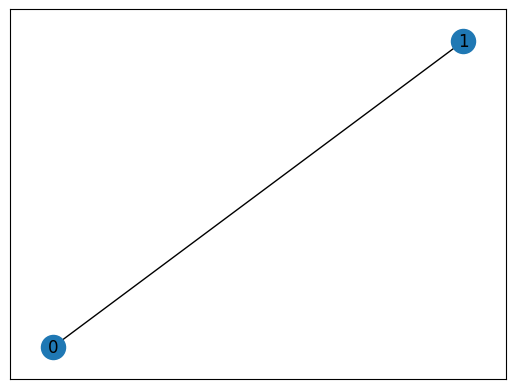

In [3]:
G = nx.Graph()
G.add_nodes_from(np.arange(0, 1, 1)) # Create a graph with 5 nodes
G.add_weighted_edges_from(
    [(0, 1, 1.0), ]
) # Add edges with weights to the graph (edge, weight)

pos = nx.spring_layout(G) # Position nodes using a spring layout
nx.draw_networkx(G, pos=pos) # Draw the graph with the specified positions

Create a MaxCut problem

Graph contains nodes with one or zero edges. These can be removed to reduce the size of the problem.


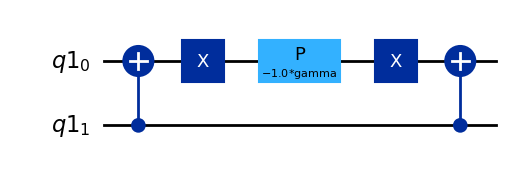

In [4]:
problem=problems.MaxKCutBinaryPowerOfTwo(G=G, k_cuts=2)
problem.create_circuit()
problem.circuit.decompose().draw(output="mpl")

Creating a QAOA instance.

Graph contains nodes with one or zero edges. These can be removed to reduce the size of the problem.


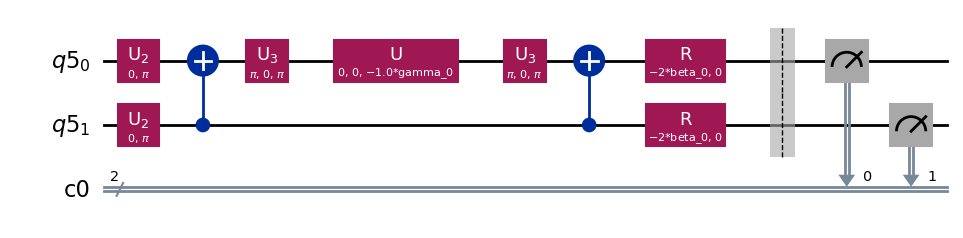

In [5]:

qaoa = QAOA(
    initialstate=initialstates.Plus(), problem=problems.MaxKCutBinaryPowerOfTwo(G=G, k_cuts=2), mixer=mixers.X()
)
qaoa.createParameterizedCircuit(1)
qaoa.parameterized_circuit.decompose().draw(output="mpl")

# Validation

In [6]:
qaoa.validate_circuit()

(np.True_,
 {'n_qubits': 2,
  'max_magnitude_error': 0.0,
  'max_phase_error_rad_after_global': 2.3419586346110148e-17,
  'global_phase_rad': -1.0})

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RZGate, RZZGate
from qiskit.quantum_info import Operator


def remove_bitstring(i, n, flip=False):
    if flip:
        return format(i, f'0{n}b')[::-1]
    else:
        return format(i, f'0{n}b')

def remove_check_phase_separator_exact_qaoa(qaoa, *arg, **kwarg):
    return check_phase_separator_exact_problem(qaoa.problem, *arg, **kwarg)

def remove_check_phase_separator_exact_problem(problem, t, flip=False, atol=1e-8, rtol=1e-8):
    """
    Exact check (uses full unitary). Suitable for <= 10 qubits (matrix is 2^n x 2^n).
    Returns: (ok: bool, report: dict)
    """
    paramed_circ = problem.circuit
    circ = paramed_circ.assign_parameters(
        {problem.circuit.parameters[0]: t},
        inplace = False
    )
    cost_fn = problem.cost

    U = Operator(circ).data  # complex ndarray
    n = circ.num_qubits
    d = 2**n
    # Compare diagonal phases to expected, modulo a global phase
    # expected diag entries
    costs = []
    for i in range(d):
        costs.append(cost_fn(bitstring(i, n, flip=flip)))
    expected = np.exp(1j * t * np.asarray(costs, dtype=float))
    

    diag = np.diag(U)
    if n < 4: 
        for i in range(d):
            print(expected[i]* diag[0], diag[i])
    # Remove global phase by aligning first nonzero expected
    ref_idx = 0
    g = diag[ref_idx] / expected[ref_idx]  # global phase factor
    ratios = diag / (expected * g)

    # Errors
    mag_err = np.max(np.abs(np.abs(diag) - 1.0))
    phase_err = np.max(np.abs(np.angle(ratios)))  # max residual phase after removing global
    ok = (mag_err <= rtol) and (phase_err <= atol)

    report = {
        "n_qubits": n,
        "max_magnitude_error": float(mag_err),
        "max_phase_error_rad_after_global": float(phase_err),
        "global_phase_rad": float(np.angle(g)),
    }
    if not ok:
        # include a few worst offenders
        idx_sorted = np.argsort(-np.abs(np.angle(ratios)))
        bad = []
        for k in idx_sorted[:8]:
            bad.append({
                "bitstring": list(bitstring(k, n, flip=flip)),
                "diag_entry": complex(diag[k]),
                "expected": complex(expected[k]*g),
                "phase_residual_rad": float(np.angle(ratios[k])),
                "magnitude": float(np.abs(diag[k])),
            })
        report["examples"] = bad
    return ok, report

# check_phase_separator_exact_problem(problem, 1, flip=False)


In [8]:
# Since this small problem is symmetrci, i validates both for big and little endians
qaoa.validate_circuit(1.5, flip=False)


(np.True_,
 {'n_qubits': 2,
  'max_magnitude_error': 0.0,
  'max_phase_error_rad_after_global': 1.6441877693909393e-18,
  'global_phase_rad': -1.5})

# Validate a larger example

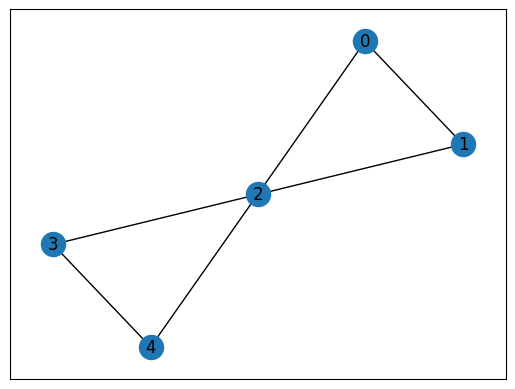

In [9]:
G_large = nx.Graph()

G_large.add_nodes_from(np.arange(0, 5, 1)) # Create a graph with 5 nodes
G_large.add_weighted_edges_from(
    [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (3, 2, 1.0), (3, 4, 1.0), (4, 2, 1.0)]
) # Add edges with weights to the graph (edge, weight)

pos_large = nx.spring_layout(G_large) # Position nodes using a spring layout
nx.draw_networkx(G_large, pos=pos_large) # Draw the graph with the specified positions

In [10]:
qaoa_larger = QAOA(
    initialstate=initialstates.Plus(), problem=problems.MaxKCutBinaryPowerOfTwo(G=G_large, k_cuts=2), mixer=mixers.X()
)
qaoa_larger.validate_circuit()

(np.True_,
 {'n_qubits': 5,
  'max_magnitude_error': 2.220446049250313e-16,
  'max_phase_error_rad_after_global': 2.520658666153901e-16,
  'global_phase_rad': 0.2831853071795869})

In [11]:
#qaoa_larger.validate_circuit(flip=False) # <--- Fails

## Validation of cicruit from weighted graph

In [12]:
G_w = nx.read_gml("data/w_ba_n10_k4_0.gml")

qaoa_w = QAOA(
    initialstate=initialstates.Plus(),
    problem=problems.MaxKCutBinaryPowerOfTwo(G=G_w, k_cuts=2),
    mixer=mixers.X()
)
qaoa_w.validate_circuit()

(np.True_,
 {'n_qubits': 10,
  'max_magnitude_error': 8.881784197001252e-16,
  'max_phase_error_rad_after_global': 1.922832498504682e-15,
  'global_phase_rad': 1.5069529291824482})